# GLM twin experiment

This script runs a twin experiment with a exp nonlinearity and a cosine basis GLM model.

In [599]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and models

import utils
import cneurons as cn
from models import cosstrf, GLM_cos

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

ch = sns.color_palette("cubehelix",8).as_hex()
ch4 = sns.color_palette("cubehelix",4).as_hex()

rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

## Setting paramters and loading data

In [551]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# glm model settings
ncos = 10
spcos = 5
dt = 0.001
tcoslin = 1000
hcoslin = 10
channels = 1

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
plen = int(np.rint(50/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]
durations = [int(d/t_dsample) for d in durations]

In [552]:
tbas, fromt, tot = utils.cosbasis(tlen,ncos,tcoslin,retfn=True)
costim = tot(tim)
 

## Simulating data for the twin experiment

### Building the STRF

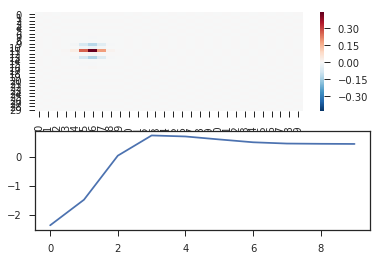

In [553]:
filts = np.load('../filters.npz')
k = resample(resample(filts['nbs'],nspec,axis=0),tlen,axis=1)

# create cosine basis for time dimension
spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(tlen,ncos,tcoslin,retfn=True)
costim = tot(tim)
 
# create post spike filter
hparam  = [-5,0,0.5,0.05,0]
tbas, fromt, tot = utils.cosbasis(tlen,ncos,tcoslin,retfn=True)

hbas, fromh, toh = utils.cosbasis(plen,spcos,hcoslin,retfn=True)
h = nf.utils.normalize(fromh(hparam))
hparam = toh(h)
subplot(211)
sns.heatmap(k)
subplot(212)
plot(h)

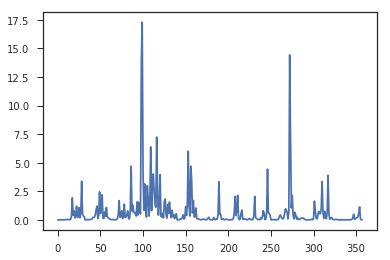

In [466]:
plot(M.run(stims[0])[0])

### Generating noisy data

In [554]:
# data settings
ntrials = 5
intercept = 2

dataparam = np.hstack(([intercept],spec[0],costim[0],hparam))
M = GLM_cos(1,nspec,tlen,plen,ncos,spcos,tcoslin,spike=True,dt=dt)
M.set(dataparam)

# generate the data
spikes_data = []
spiky_data = []
binary_data = []
model_data   = []
for s,dur in zip(stims,durations):
    sr = []
    sspk = []
    s0 = []
    sspiky = []
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        sspiky.append(pyspk.SpikeTrain(spikes,[0,dur]))
        s0.append(z)
    model_data.append(sr)
    spikes_data.append(sspk)
    spiky_data.append(sspiky)
    binary_data.append(s0)
psth_data = [utils.psth(spk,dur,psth_smooth) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,psth_smooth,0) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.90


## Getting initial guess for STRF

In [469]:
# estimate STRF using elastic net regression
fit_psth = [np.log(p*1000 + 1) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=True)
SPEC,TIM = utils.factorize(STRF_GUESS,1)

# create initial paramter vector from estimated strf
filt_start = np.hstack(([[B_GUESS]],SPEC,tot(TIM))).flatten()

0.528868729768


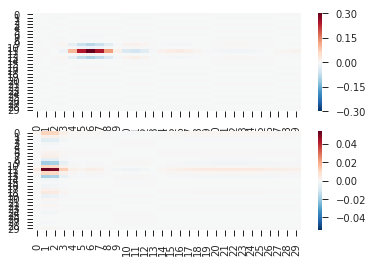

In [468]:
# plot true and estimated strf
subplot(211)
sns.heatmap(M.k.filt)

subplot(212)
strf_model = cosstrf(channels,nspec,tlen,ncos,tcoslin)
strf_model.set(filt_start[1:])
sns.heatmap(strf_model.filt)

print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [212]:
from neurofit import priors
from neurofit import costs


def pploss(predict,data):
    lam,spikes = predict
    if np.shape(lam[0]) == ():
        lam = [lam]
        spikes = [spikes]
    return -np.sum([np.sum(np.log(l[s])) - np.sum(l) for s,l in zip(spikes,lam)])

def l1_prior(theta):
    return -np.sum(np.abs(theta))

def cost(theta, model, lnprior, lnlike, observs,fixed):

    lp = lnprior(theta)
    if not np.isfinite(lp): return -np.inf
    params = np.hstack((fixed,theta))
    model.set(params)
    
    ll = 0
    for stim, data, in observs:
        ll += lnlike(model.run(stim), data)
        if np.isnan(ll): return -np.inf
        
    return -ll + lp

## Run initial post spike filter fit

In [213]:
# initalize the model
model = GLM_cos(channels,nspec,tlen,plen,ncos,spcos,tcoslin,hcoslin,nonlin=np.exp,spike=True,dt=dt)

data = zip(zip(test_stims,test_spikes),test_psth)

ncost = lambda *args: -cost(*args)

from scipy import optimize as opt

fixed = filt_start
%time result = opt.minimize(ncost,[0]*5,args=(model,priors.unbounded(),pploss,data,fixed))

CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.3 s


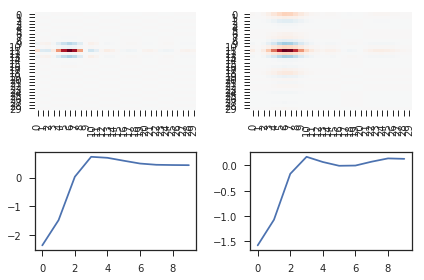

In [463]:
start = np.hstack((fixed,result['x']))
model.set(start)

subplot(221)
sns.heatmap(M.k.filt,cbar=False)

subplot(222)
sns.heatmap(model.k.filt,cbar=False)

subplot(223)
plot(h)

subplot(224)
plot(model.h.filt.T)

tight_layout()

## Fit GLM model using emcee

In [215]:
# set starting positions for walkers
p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))

# run emcee
glm_smplr = nf.sampler(model,l1_prior,pploss,nwalkers,zip(zip(assim_stims,assim_spikes),test_psth),threads)
for pos,_,_ in tracker(glm_smplr.sample(p0,iterations=burn)): continue
glm_smplr.reset()
glm_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -3704.3     0:01:45     0:15:56
   200     -3630.1     0:04:17     0:17:16
   300     -3564.4     0:06:49     0:15:59
   400     -3516.1     0:09:19     0:14:03
   500     -3476.5     0:11:56     0:11:59
   600     -3442.2     0:14:51     0:09:56
   700     -3406.3     0:18:03     0:07:46
   800     -3385.3     0:21:16     0:05:21
   900     -3373.9     0:24:26     0:02:44
  1000     -3367.3     0:27:37     0:00:01
  1001     -3367.4     0:27:39     0:00:00


## Evaluate the model fit

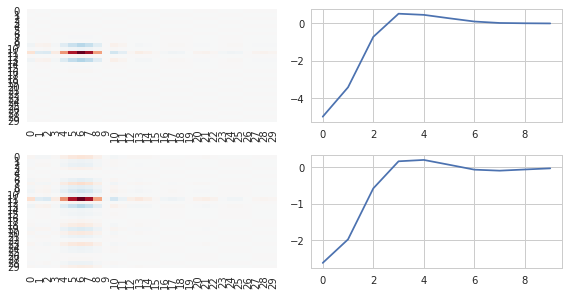

In [216]:
# initalize model with MAP parameter estimate
dmap = glm_smplr.flatchain[np.argmax(glm_smplr.flatlnprobability)]
chain = glm_smplr.flatchain
model.set(np.mean(chain,0))

figure(figsize=(8,8))
# compare true and estimated STRFs
subplot(421)
sns.heatmap(M.k.filt,cbar=False)

subplot(422)
plot(M.h.filt.T)

subplot(423)
sns.heatmap(model.k.filt,cbar=False)
tight_layout()

subplot(424)
plot(model.h.filt.T)

In [218]:
model = GLM_cos(channels,nspec,tlen,plen,ncos,spcos,tcoslin,hcoslin,nonlin=np.exp,spike=True,dt=dt)
model.set(dmap)

map_corr = utils.glm_sample_validate(model,dmap,test_stims,test_psth,ntrials=10,dsample=1,smooth=psth_smooth)
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,glm_smplr.flatchain,1,psth_smooth,ntrials=100)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.86, Dist: 0.92, EO: 0.79
MAP/EO: 1.09, Dist/EO: 1.16


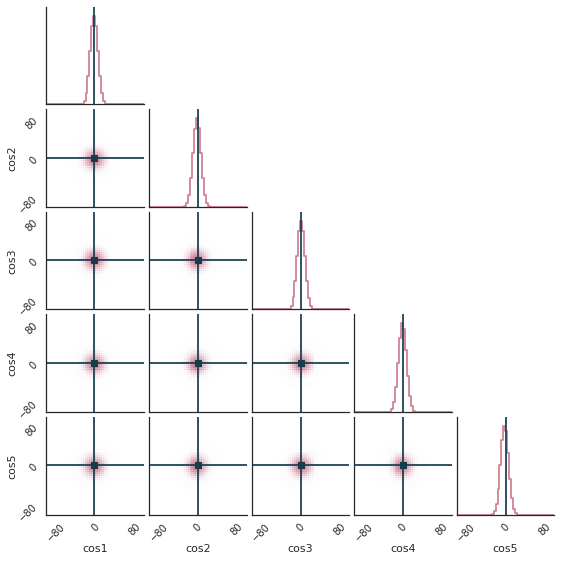

In [477]:
sns.set_style("white")
from corner import corner
matlabs = ['cos1','cos2','cos3','cos4','cos5']
fig = corner(glm_smplr.flatchain[:,-5:],
       range=[[-100,100],
              [-100,100],
              [-100,100],
              [-100,100],
              [-100,100]],
       bins=50, smooth=4,smooth1d=2,
       labels=matlabs,
       truths=hparam,plot_contours=False,max_n_ticks=3,truth_color=ch4[0],color=ch4[2]);

fig.set_size_inches(8,8)
sns.despine()

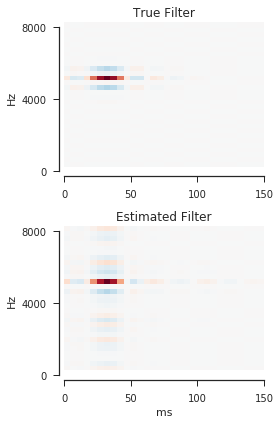

In [604]:
figroot = "/scratch/dstrf/figures/glm_twin/"


sns.set_style("ticks")

figure(figsize=(4,6))
model.set(np.mean(chain,0))

from neurofit import graphics

#figure()
subplot(211)
title("True Filter")
#graphics.strf_plot(M.k.sfilt,M.k.tfilt,0,8000,t_dsample)
sns.heatmap(M.k.filt,cbar=False)

yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
xticks([0,10,20,30],[0,50,100,150])
ylabel("Hz")


subplot(212)
title("Estimated Filter")
sns.heatmap(model.k.filt,cbar=False)
yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
xticks([0,10,20,30],[0,50,100,150])
xlabel("ms")
ylabel("Hz")

sns.despine(trim=True, offset=5)
tight_layout()
#graphics.strf_plot(model.k.sfilt,model.k.tfilt,0,8000,t_dsample)

savefig(figroot+"strf.svg",bbox_inches='tight')

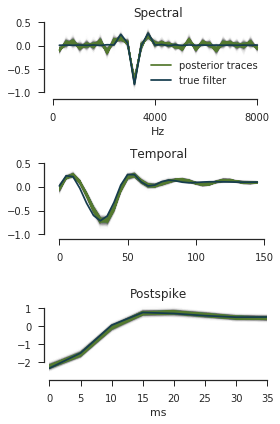

In [602]:
figure(figsize=(4,6))

sns.set_style("ticks")

subplot(311)
title("Spectral")
x = np.arange(0,nspec)
plot(nfutils.normalize(chain[:,1:-15].T)/6,color=ch4[1],alpha=0.005)
plot(nfutils.normalize(model.k.sfilt.T)/6,ch4[1],label="posterior traces")
plot(nfutils.normalize(M.k.sfilt.T)/6,ch4[0],label="true filter")
legend()

#yticks([])
title("Spectral")
xticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
yticks([-1,-0.5,0,0.5])
xlabel("Hz")

subplot(312)
title("Temporal")
x = np.arange(0,nspec)
plot(nfutils.normalize(fromt(chain[:,nspec+1:-spcos]).T)/4,color=ch4[1],alpha=0.005)
plot(nfutils.normalize(M.k.tfilt.T)/4,ch4[0],label="true filter")
yticks([-1,-0.5,0,0.5])
xticks([0,10,20,30],[0,50,100,150])

subplot(313)
title("Postspike")
plot(nfutils.normalize(fromh(chain[:,-spcos:]).T),color=ch4[1],alpha=0.005)
plot(nfutils.normalize(M.h.filt[0]),ch4[0],label="true filter")

xticks(range(0,8),range(0,8*5,5))
xlabel("ms")
xlim(0,7)


sns.despine(offset=5,trim=True)
tight_layout()

savefig(figroot+"marg.svg",bbox_inches='tight')